In [1]:
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_array
import matplotlib.pyplot as plt
from _FigureJiazeHelper import *
from _HyperSBM import *
from _HyperCommunityDetection import *
import pickle
import warnings
import pandas
import time
import hypernetx as hnx
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
# plt.rc('font', family='sans-serif')
# plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

# Data Prepare

In [3]:
def save_idmap(path, d):
    with open(path, 'w') as f:
        for k in d.keys():
            f.write(f"{k} {d[k]}\n")

            
def load_idmap(path):
    d = dict()
    with open(path, 'r') as f:
        for line in f.readlines():
            line = line.strip().split(' ')
            d[int(line[0])] = int(line[1])
    return d

In [4]:
class APS:
    def __init__(self):
        self.author_n = 0
        self.paper_n = 0
        self.incidence_H = None  # authors * papers
        self.citation_A = None  # papers * papers
        self.construct()
    
    def construct(self):
        authorship_file = "./aps/data/authorships_afterdisambiguation.csv"
        # Construct authorship incidence matrix (Bipartite or Hyper)
        with open(authorship_file, 'r') as fr:
            fr.readline()
            data = []
            row_ind = []
            col_ind = []
            author_ids = []
            paper_ids = []
            author_papers = set()
            for line in tqdm(fr.readlines(), desc='Load Authorship'):
                line = line.strip().split(',')
                paper_id = int(line[0])
                author_id = int(line[1])
                if (author_id, paper_id) not in author_papers:
                    author_papers.add((author_id, paper_id))
                else:
                    continue
                    # print(f"{(author_id, paper_id)} repeats") # There are some author paper repeat in file
                # if paper_id > 0 and paper_id - col_ind[-1] >= 2:
                #     print(paper_id)
                author_ids.append(author_id)
                paper_ids.append(paper_id)
                data.append(1)
            # check the authoid and paperid in file is not continues
            # print(f"{np.size(np.unique(author_ids))}, {max(author_ids)}, {np.size(np.unique(paper_ids))}, {max(paper_ids)}")
            unique_author_ids = np.unique(author_ids)
            self.author_n = np.size(np.unique(author_ids))
            authorId_map_ind = dict({unique_author_ids[i]:i for i in range(self.author_n)})
            
            # For paper we don't unique that considering the citation part
            # unique_paper_ids = np.unique(paper_ids)
            # self.paper_n = np.size(np.unique(unique_paper_ids))
            # paperId_map_ind = dict({unique_paper_ids[i]:i for i in range(self.paper_n)})
            self.paper_n = np.max(paper_ids)+1
            # TODO save these map for check
            save_authorId_map = "./aps/authorId_map_ind.txt"
            save_idmap(save_authorId_map, authorId_map_ind)
            
            row_ind = [authorId_map_ind[aid] for aid in author_ids]
            col_ind = paper_ids
            self.incidence_H = csr_array((data, (row_ind, col_ind)))
            print(f"Number of Author {self.author_n}, Number of Paper {self.paper_n} \n", 
                  f"Average #_papers per author {self.incidence_H.sum() / self.author_n} \n", 
                  f"Average #_coauthors per paper {self.incidence_H.sum() / self.paper_n} \n")
        
        citation_file = "./aps/data/citations_withID.csv"
        # Construct citation adjacent matrix (Directed network)
        with open(citation_file, 'r') as fr:
            fr.readline()
            data = []
            citing_ids = []
            cited_ids = []
            for line in tqdm(fr.readlines(), desc='Load Citation'):
                line = line.strip().split(',')
                citing_id = int(float(line[2]))
                cited_id = int(float(line[3]))
                citing_ids.append(citing_id)
                cited_ids.append(cited_id)
                data.append(1)
                # Check there are some paper cited but no author
                # if citing_id not in paperId_map_ind.keys() or cited_id not in paperId_map_ind.keys():
                #     print(f"{citing_id}, {cited_id} is not in authorship file")
            # print(f"{np.size(np.unique(citing_ids))}, {max(citing_ids)}, {np.size(np.unique(cited_ids))}, {max(cited_ids)}")
            self.citation_A = csr_array((data, (citing_ids, cited_ids)), shape=(self.paper_n, self.paper_n))
            print(f"Average #_cited_papers per citing_paper {self.citation_A.sum() / self.paper_n} \n")
            
    def papers_info(self, paper_ids, paper_partition, save_path):
        partition_dict = dict(zip(paper_ids, paper_partition))
        
        paper_path = "./aps/meta/publications.csv"
        if save_path is not None:
            paper_info_path = save_path
        else:
            paper_info_path = "./aps/result/paper_partition_info.csv"  # to save
        # Load topics
        paper_topic_path = "./aps/meta/publication_topics.csv"
        paper_topics = dict({i:{0:[], 1:[], 2:[], 'primary_topic(concept)':-1} for i in range(self.paper_n)})
        topic_type = dict({0:"area", 1:"discipline", 2:"concept"})
        with open(paper_topic_path, 'r') as fr:
            fr.readline()
            for line in tqdm(fr.readlines(), desc='Load paper_topics'):
                line = line.strip().split(',')
                paper_topics[int(line[0])][int(line[2])].append(int(line[1]))
                if line[-1] == "True":
                    paper_topics[int(line[0])]['primary_topic(concept)'] = int(line[1])
        # Load topic names
        areas = dict()
        with open("./aps/meta/areas.csv", 'r') as fr:
            fr.readline()
            for line in tqdm(fr.readlines(), desc='Load areas'):
                line = line.strip().split(',')
                areas[int(line[0])] = line[2]
        disciplines = dict()
        with open("./aps/meta/disciplines.csv", 'r') as fr:
            fr.readline()
            for line in tqdm(fr.readlines(), desc='Load disciplines'):
                line = line.strip().split(',')
                disciplines[int(line[0])] = line[2]
        concepts = dict()
        with open("./aps/meta/concepts.csv", 'r') as fr:
            fr.readline()
            for line in tqdm(fr.readlines(), desc='Load concepts'):
                line = line.strip().split(',')
                concepts[int(line[0])] = line[3]
        # Load paper and write
        with open(paper_path, 'r') as fr:
            with open(paper_info_path, 'w') as fw:
                fw.write("id_publication,id_journal,timestamp,doi,areas,disciplines,concepts,primary_concept,partitions\n")
                fr.readline()
                for rline in tqdm(fr.readlines(), desc='Load papers'):
                    wline = rline.strip().split(',')
                    pid = int(wline[0])
                    wline.append(" ".join([str(i) for i in sorted(paper_topics[pid][0])]))
                    wline.append(" ".join([str(i) for i in sorted(paper_topics[pid][1])]))
                    wline.append(" ".join([str(i) for i in sorted(paper_topics[pid][2])]))
                    wline.append(str(paper_topics[pid]['primary_topic(concept)']))
                    if pid in partition_dict.keys():
                        wline.append(str(partition_dict[pid]))
                    else:
                        wline.append("")
                    wline = ",".join(wline)
                    fw.write(wline+"\n")
                    

In [93]:
aps = APS()

Load Authorship: 100%|██████████| 2385375/2385375 [00:04<00:00, 575975.85it/s]


Number of Author 868506, Number of Paper 678916 
 Average #_papers per author 2.7464692241619515 
 Average #_coauthors per paper 3.5134317058369517 



Load Citation: 100%|██████████| 8767868/8767868 [00:16<00:00, 521286.64it/s]


Average #_cited_papers per citing_paper 12.914510778947616 



In [19]:
np.unique(aps.incidence_H.data, return_counts=True)

(array([1]), array([2385325]))

# CD based on Hypergraph on papers

In [7]:
class HyperPaper(APS):
    def __init__(self):
        super().__init__()
        self.n = self.paper_n
        self.e = self.author_n
        self.H = self.incidence_H.transpose()
        
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        print(f"There are {order_count[0]} authors with 1 paper: number of order_1 hyperedge. To be removed!")
        self.e = self.e - order_count[0]
        nonorder1_column = (self.H.sum(axis=0).flatten()!=1).nonzero()
        self.H = (self.H.tocsc()[:, nonorder1_column[0]]).tocsr()
        # print(np.unique(self.H.data, return_counts=True))
        
        node_degree, degree_count = np.unique(self.H.sum(axis=1).flatten(),  return_counts=True)
        print(f"There are {degree_count[0]} papers with 0 author: number of degree_0 nodes. To be removed!")
        self.n = self.n - degree_count[0]
        self.nondegree0_row = (self.H.sum(axis=1).flatten()!=0).nonzero()
        self.nodes = self.nondegree0_row[0]
        self.H = self.H[self.nondegree0_row[0], :]
        
        # self.max_component()
        
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        self.Ks = edge_order
        self.summary()
    
    def summary(self):
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        node_degree, degree_count = np.unique(self.H.sum(axis=1).flatten(),  return_counts=True)
        print(f"Hypergraph on papers, each author is a hyperedge. n={self.n}, e={self.e}\n Ks & #hyperedge per order={np.array([edge_order, order_count])}")
        print(f"Ds & #nodes per degree={np.array([node_degree, degree_count])}")
    
    
    def max_component(self, connected_components=None):
        if connected_components is None:
            hyper_g = hnx.Hypergraph.from_incidence_matrix(self.H)
            connected_components = list(hyper_g.s_connected_components(edges=False))
        print(f"There are {len(connected_components)} connected components now, we select the maximum one")
        max_component = np.array(list(connected_components[0]))
        self.H = self.H[max_component, :]  # Directly cut the nodes in max component
        self.nodes = self.nondegree0_row[0][max_component]
        self.n = np.size(max_component)
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        print(f"There are {order_count[0]} authors with {edge_order[0]} paper after select max component: To be removed!")
        self.e = self.e - order_count[0]
        nonorder0_column = (self.H.sum(axis=0).flatten()!=0).nonzero()
        self.H = (self.H.tocsc()[:, nonorder0_column[0]]).tocsr()
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        node_degree, degree_count = np.unique(self.H.sum(axis=1).flatten(),  return_counts=True)
        self.Ks = edge_order
        self.summary()
        
    def get_operator(self, operator='BH', r=0, consider_ks=None):
        if operator == "BH":
            edge_order = self.H.sum(axis=0).flatten()
            D = None
            A = None
            self.H = self.H.tocsc()
            if consider_ks is None:
                Ks = self.Ks
            else:
                Ks = consider_ks
            for k in tqdm(Ks, desc='Constructing HyperBH...'):
                edge_index = np.where(edge_order == k)[0]
                Hk = self.H[:, edge_index]
                Dk = diags(Hk.sum(axis=1).flatten().astype(float))
                Ak = Hk.dot(Hk.T) - diags(Hk.dot(Hk.T).diagonal())
                if D is None:
                    D = (k-1)/((1-r)*(r+k-1))*Dk
                else:
                    D += (k-1)/((1-r)*(r+k-1))*Dk
                if A is None:
                    A = r/((1-r)*(r+k-1))*Ak
                else:
                    A += r/((1-r)*(r+k-1))*Ak
            B = eye(D.shape[0]) - D + A
            return B
        elif operator == "binary_proj_L":
            projA = self.H.dot(self.H.T)
            projA = projA - diags(projA.diagonal())
            projA[projA > 0] = 1
            D = diags(projA.sum(axis=0))
            L = D - projA
            print(L[:10, :10])
            return L

In [58]:
aps_hyper_paper = HyperPaper()

Load Authorship: 100%|██████████| 2385375/2385375 [00:04<00:00, 561199.10it/s]


Number of Author 868506, Number of Paper 678916 
 Average #_papers per author 2.7464692241619515 
 Average #_coauthors per paper 3.5134317058369517 



Load Citation: 100%|██████████| 8767868/8767868 [00:17<00:00, 494793.15it/s]


Average #_cited_papers per citing_paper 12.914510778947616 

There are 661105 authors with 1 paper: number of order_1 hyperedge. To be removed!
There are 75916 papers with 0 author: number of degree_0 nodes. To be removed!
Hypergraph on papers, each author is a hyperedge. n=603000, e=207401
 Ks & #hyperedge per order=[[    2     3     4     5     6     7     8     9    10    11    12    13
     14    15    16    17    18    19    20    21    22    23    24    25
     26    27    28    29    30    31    32    33    34    35    36    37
     38    39    40    41    42    43    44    45    46    47    48    49
     50    51    52    53    54    55    56    57    58    59    60    61
     62    63    64    65    66    67    68    69    70    71    72    73
     74    75    76    77    78    79    80    81    82    83    84    85
     86    87    88    89    90    91    92    93    94    95    96    97
     98    99   100   101   102   103   104   105   106   107   108   109
    110   111  

In [ ]:
# Try laplacian to find connected components
start = time.time()
L = aps_hyper_paper.get_operator("binary_proj_L")
evals = eigsh(L, 10, which="SA", tol=1e-6, return_eigenvectors=False)
print(f"Time: {time.time()-start}, EigVals={evals}")

In [10]:
hyper_g = hnx.Hypergraph.from_incidence_matrix(aps_hyper_paper.H)
connected_components = list(hyper_g.s_connected_components(edges=False))

In [55]:
print(len(connected_components[0]))
# print([len(com) for com in connected_components])
print(np.shape(aps_hyper_paper.nondegree0_row[0]))
print(np.shape(np.array(list(connected_components[0]))))
print(np.array(list(connected_components[0])).dtype)

583905
(603000,)
(583905,)
int64


In [59]:
aps_hyper_paper.max_component(connected_components=connected_components)

There are 5675 connected components now, we select the maximum one
There are 8792 authors with 0 paper after select max component: To be removed!
Hypergraph on papers, each author is a hyperedge. n=583905, e=198609
 Ks & #hyperedge per order=[[    2     3     4     5     6     7     8     9    10    11    12    13
     14    15    16    17    18    19    20    21    22    23    24    25
     26    27    28    29    30    31    32    33    34    35    36    37
     38    39    40    41    42    43    44    45    46    47    48    49
     50    51    52    53    54    55    56    57    58    59    60    61
     62    63    64    65    66    67    68    69    70    71    72    73
     74    75    76    77    78    79    80    81    82    83    84    85
     86    87    88    89    90    91    92    93    94    95    96    97
     98    99   100   101   102   103   104   105   106   107   108   109
    110   111   112   113   114   115   116   117   118   119   120   121
    122   123   12

In [71]:
def cd_apshyperpaper(aps_hyper_paper, given_num_groups=3, consider_ks=None, save_path=None, BHposOperator=None):
    partition_vec, num_groups = HyperCommunityDetect().BetheHessian(aps_hyper_paper, 
                                                                    num_groups=given_num_groups,
                                                                    consider_ks=consider_ks,
                                                                    only_assortative=True, 
                                                                    BHposOperator=BHposOperator)
    if save_path is None:
        save_path = f"./result/partition_paper_hyperBH_given{given_num_groups}Groups_consider{consider_ks}Orders.pkl"
    with open(save_path, "wb") as fw:
            pickle.dump(partition_vec, fw)
    return partition_vec

In [15]:
def get_filter_paper_topics(filter_papers, topic_type=1):
    """
    topic_type: 1-discipline, 2-concept
    """
    filter_paper_topics = dict({filter_pid:[] for filter_pid in filter_papers})  # filtered paper id
    paper_topics = "./aps/meta/publication_topics.csv"
    with open(paper_topics, 'r') as fr:
        fr.readline()
        annoted_papers = set()
        for line in tqdm(fr.readlines(), desc='Load paper_topics'):
            line = line.strip().split(',')
            annoted_papers.add(int(line[0]))
            if int(line[2]) == topic_type:  # topic type is discipline
                # paper id in filtered paper which have author (remove unexist paperid) and 
                # whose author have more than 1 paper (remove the paper whose authors only have this paper).
                if int(line[0]) in filter_paper_topics.keys():
                    filter_paper_topics[int(line[0])].append(int(line[1]))  # add topic id
                else:
                    pass
        print(f"There are {len(annoted_papers)} papers annoted")
        filter_paper_topic_nums = [len(temp) for temp in filter_paper_topics.values()]
        print(f"unique topic_num per filter paper & their counts\n: {np.unique(filter_paper_topic_nums, return_counts=True)}")
        return filter_paper_topics

In [16]:
def get_cm(trueMeta, cdLabel):
    """
    trueMeta: {nodeId: [metas]}
    cdLabel: {nodeId: cd label}
    """
    trueMetaLabels = set()
    cdLabels = set()
    for node in trueMeta.keys():
        for l in trueMeta[node]:
            trueMetaLabels.add(l)
        cdLabels.add(cdLabel[node])
    confusionMatrix = np.zeros((len(trueMetaLabels), len(cdLabels)))
    trueMetaLabels = np.array(sorted(list(trueMetaLabels)))
    cdLabels = np.array(sorted(list(cdLabels)))
    for iTrue in trueMetaLabels:
        trueIndex = []
        for node in trueMeta.keys():
            if iTrue in trueMeta[node]:
                trueIndex.append(node)
        for iCD in cdLabels:
            i = np.where(trueMetaLabels == iTrue)
            j = np.where(cdLabels == iCD)
            num_fit = 0
            for node in trueIndex:
                if cdLabel[node] == iCD:
                    num_fit += 1
            confusionMatrix[i, j] = num_fit
    # print(confusionMatrix)
    true_ind, CD_ind = linear_sum_assignment(confusionMatrix, maximize=True)
    print(f'True index is {true_ind}, Community detected index is {CD_ind}')
    confusionMatrix[:, np.sort(CD_ind)] = confusionMatrix[:, CD_ind]
    df = pandas.DataFrame(confusionMatrix, trueMetaLabels, cdLabels)
    return confusionMatrix, CD_ind, df

In [26]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [20]:
def plot_cm(confusionMatrix, fig=None, ax=None):
    subTrueNumgroup,subBHNumgroup = np.shape(confusionMatrix)
    rowsum = np.sum(confusionMatrix, axis=1)
    rowsum = rowsum.reshape(-1, 1)
    rowsum = np.repeat(rowsum, subBHNumgroup, axis=1)
    normConfusionMatrix = np.round(confusionMatrix / rowsum, 2)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(3, 3))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
#     cmap = mpl.colormaps["bwr_r"]
#     cmap = mpl.colormaps["RdYlBu"]
    cmap = mpl.colormaps["seismic_r"]
    cmap = truncate_colormap(cmap, 0.3, 0.7)
    im = ax.matshow(normConfusionMatrix, cmap=cmap, vmin=0, vmax=1)
    for i in range(subTrueNumgroup):
        for j in range(subBHNumgroup):
            c = normConfusionMatrix[i,j]
            ax.text(j, i, str(c), va='center', ha='center', fontsize=3)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    return im

## CD with hyper bh

In [62]:
given_num_groups = 51
consider_ks = None
save_path = f"./result/partition_paper_hyperBH_maxcomponent_given{given_num_groups}Groups_consider{consider_ks}Orders.pkl"
partition_vec = cd_apshyperpaper(aps_hyper_paper, given_num_groups=given_num_groups, consider_ks=consider_ks, save_path=save_path)

Constructing HyperBH...: 100%|██████████| 277/277 [23:52<00:00,  5.17s/it]


EVECs construct: 1615.301501750946


In [63]:
print(partition_vec)
np.unique(partition_vec, return_counts=True)

[0 0 0 ... 0 0 0]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
       dtype=int32),
 array([563672,     29,     20,     81,     65,    166,     21,     64,
            24,     41,     13,     28,     90,     21,     35,     63,
            54,    236,     25,    103,     62,      8,     38,     32,
            60,    126,     43,     23,    236,     92,     65,    156,
           398,  10325,    435,     49,     42,    261,     50,     27,
            25,   2924,     42,   1773,     60,    271,     51,    666,
           593,     73,     48]))

In [64]:
start = time.time()
given_num_groups = 51
edge_order, order_count = np.unique(aps_hyper_paper.H.sum(axis=0).flatten(), return_counts=True)
consider_ks = []
for i in range(np.size(order_count)):
    if order_count[i] > 20:
        consider_ks.append(edge_order[i])
print(f"Consider Orders with greater than 20 hyperedges: {consider_ks}")
# consider_ks = None
save_path = f"./result/partition_paper_hyperBH_maxcomponent_given{given_num_groups}Groups_considerOrdersWithGreaterThan20hedges.pkl"
partition_vec = cd_apshyperpaper(aps_hyper_paper, given_num_groups=given_num_groups, consider_ks=consider_ks, save_path=save_path)
print(f"Time cost {time.time()-start}")

Consider Orders with greater than 20 hyperedges: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 108, 109, 110, 112, 117, 127]


Constructing HyperBH...: 100%|██████████| 108/108 [09:03<00:00,  5.03s/it]


EVECs construct: 756.4003014564514


In [65]:
print(partition_vec)
np.unique(partition_vec, return_counts=True)

[0 0 0 ... 0 0 0]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
       dtype=int32),
 array([569175,     35,    127,     20,     24,     21,     28,     25,
            38,     54,     62,     83,      8,     40,     33,     27,
            29,     48,     21,     65,     92,     32,     13,     69,
            90,     65,     43,     65,     42,     42,     25,     33,
            67,     40,     24,     48,     73,     64,     73,     39,
           217,    100,    813,    103,     81,     11,    163,     49,
          9135,     23,   2208]))

In [66]:
start = time.time()
given_num_groups = 51
edge_order, order_count = np.unique(aps_hyper_paper.H.sum(axis=0).flatten(), return_counts=True)
consider_ks = []
for i in range(np.size(order_count)):
    if order_count[i] > 1000:
        consider_ks.append(edge_order[i])
print(f"Consider Orders with greater than 1000 hyperedges: {consider_ks}")
# consider_ks = None
save_path = f"./result/partition_paper_hyperBH_maxcomponent_given{given_num_groups}Groups_considerOrdersWithGreaterThan1000hedges.pkl"
partition_vec = cd_apshyperpaper(aps_hyper_paper, given_num_groups=given_num_groups, consider_ks=consider_ks, save_path=save_path)
print(f"Time cost {time.time()-start}")

Consider Orders with greater than 1000 hyperedges: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


Constructing HyperBH...: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


EVECs construct: 169.9487862586975
Time cost 360.5722007751465


In [67]:
print(partition_vec)
np.unique(partition_vec, return_counts=True)

[0 0 0 ... 0 0 0]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
       dtype=int32),
 array([583086,     13,     16,     13,     20,     12,     25,      5,
            20,     11,     19,     11,     10,      9,     11,     15,
             8,     17,     13,      5,     16,     17,     18,     14,
            15,     13,     27,     13,     13,     20,     15,     10,
            10,     16,      9,     14,     18,     11,     17,     48,
             7,     25,     64,     18,      9,     12,     15,     11,
            22,      6,     43]))

In [68]:
start = time.time()
given_num_groups = 51
edge_order, order_count = np.unique(aps_hyper_paper.H.sum(axis=0).flatten(), return_counts=True)
consider_ks = [2, 3, 4, 5]
print(f"Consider Orders: {consider_ks}")
# consider_ks = None
save_path = f"./result/partition_paper_hyperBH_maxcomponent_given{given_num_groups}Groups_considerOrders{consider_ks}.pkl"
partition_vec = cd_apshyperpaper(aps_hyper_paper, given_num_groups=given_num_groups, consider_ks=consider_ks, save_path=save_path)
print(f"Time cost {time.time()-start}")

Consider Orders: [2, 3, 4, 5]


Constructing HyperBH...: 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


EVECs construct: 147.9569549560547
Time cost 386.3707718849182


In [70]:
print(partition_vec)
np.unique(partition_vec, return_counts=True)

[0 0 0 ... 0 0 0]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
       dtype=int32),
 array([583687,      4,      4,      5,      5,      5,      4,      5,
             4,      3,      4,      5,      5,      5,      5,      3,
             5,      4,      4,      3,      5,      4,      4,      3,
             4,      5,      4,      4,      5,      4,      5,      3,
             5,      5,      4,      5,      5,      5,      5,      3,
             5,      4,      5,      3,      4,      4,      3,      5,
             7,      5,      4]))

In [79]:
start = time.time()
given_num_groups = 168
edge_order, order_count = np.unique(aps_hyper_paper.H.sum(axis=0).flatten(), return_counts=True)
consider_ks = None
print(f"Consider Orders: {consider_ks}")
# consider_ks = None
save_path = f"./result/partition_paper_hyperBH_maxcomponent_given{given_num_groups}Groups_considerOrders{consider_ks}.pkl"
partition_vec = cd_apshyperpaper(aps_hyper_paper, given_num_groups=given_num_groups, consider_ks=consider_ks, 
                                 save_path=save_path, BHposOperator=BH.operator)
print(f"Time cost {time.time()-start}")

Consider Orders: None
EVECs construct: 1101.066344499588
Time cost 3040.2490570545197


In [80]:
print(partition_vec)
np.unique(partition_vec, return_counts=True)

[0 0 0 ... 0 0 0]


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
       dtype=int32),
 array([554436,     90,     62,   

In [94]:
save_path = f"./result/partition_paper_hyperBH_maxcomponent_given{given_num_groups}Groups_considerOrders{consider_ks}.csv"
aps.papers_info(aps_hyper_paper.nodes, partition_vec, save_path=save_path)

Load papers: 100%|██████████| 678916/678916 [00:04<00:00, 168034.30it/s]


## visulization with confusion matrix

In [24]:
filter_paper_topics = get_filter_paper_topics(filter_papers=aps_hyper_paper.nondegree0_row[0], topic_type=1)
filter_paper_cdlabel = dict(zip(aps_hyper_paper.nondegree0_row[0], partition_vec))
components_vec = np.zeros(np.size(aps_hyper_paper.nondegree0_row[0]))
component_id = 0
for nodes in connected_components:
    for node in nodes:
        components_vec[node] = component_id
    component_id += 1
filter_paper_components = dict(zip(aps_hyper_paper.nondegree0_row[0], components_vec))

Load paper_topics: 100%|██████████| 597018/597018 [00:00<00:00, 767678.22it/s]


There are 101277 papers annoted
unique topic_num per filter paper & their counts
: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 17]), array([516730,  63593,  15490,   5153,   1452,    403,    116,     38,
            9,      4,      1,      1,     10]))


True index is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], Community detected index is [37  1 49 33 27 40  0 31  2  5 47 50 41  3  4 44 20]


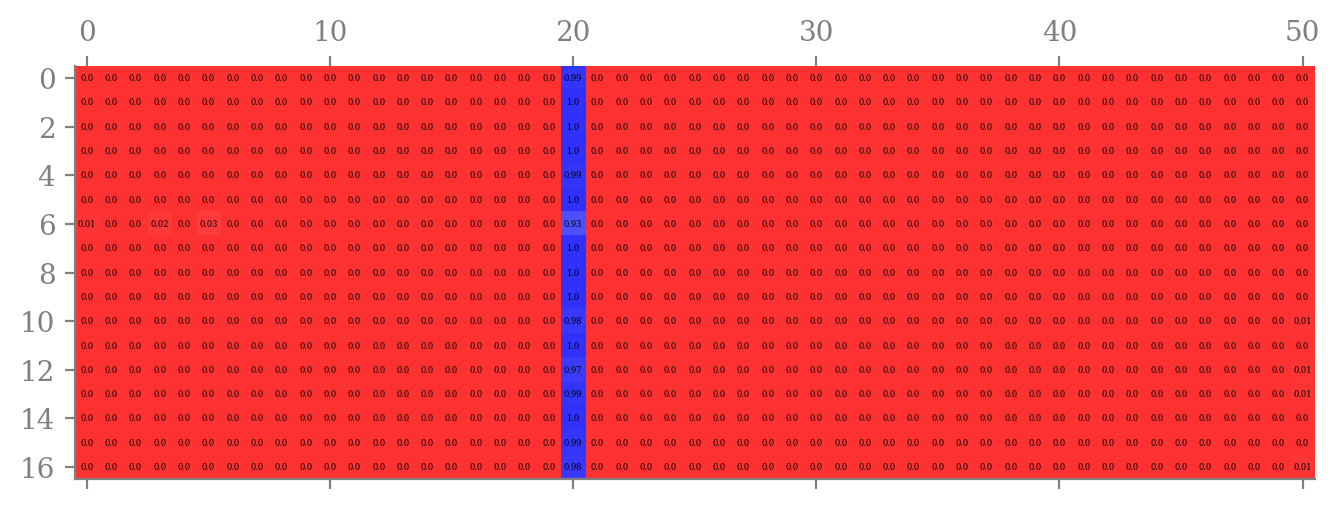

In [21]:
cm, _, df = get_cm(filter_paper_topics, filter_paper_cdlabel)
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
plot_cm(cm, fig=fig, ax=ax)

In [ ]:
path = f'./result/aps_hyperpaper_cm_giveq={given_num_groups}.xlsx'
with pandas.ExcelWriter(path) as writer:
    df.to_excel(excel_writer=writer)
    writer.save()

## compare partition and connected component

In [27]:
cm, _ = get_confusionmatrix(partition_vec, components_vec, 
                            trueNumgroup=given_num_groups, 
                            cdNumgroup=len(connected_components))
# fig = plt.figure(figsize=(8, 8))
# widths = [4]
# heights = [4]
# spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
# row = 0
# col = 0
# ax = fig.add_subplot(spec5[row, col])
# plot_cm(cm, fig=fig, ax=ax)

True index is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50], Community detected index is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


In [29]:
uniquePartition = np.unique(partition_vec)
uniqueComponent = np.unique(components_vec)
df = pandas.DataFrame(cm, uniquePartition, uniqueComponent)
path = f'./result/aps_hyperpaper_partition_component_cm_giveq={given_num_groups}.xlsx'
with pandas.ExcelWriter(path) as writer:
    df.to_excel(excel_writer=writer)
    writer._save()

In [30]:
print(df)

      0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0     \
0   559786.0     2.0     7.0     5.0     2.0     3.0     2.0     2.0     6.0   
1       23.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2       90.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3       13.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4       41.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5       54.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6       60.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7      126.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8        8.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9       21.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10      62.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
11      20.0     0.0     0.0     0.0    

## explore BH eigenvalues

In [73]:
edge_order, edge_count = np.unique(aps_hyper_paper.H.sum(axis=0).flatten(), return_counts=True)
order_count = dict(zip(edge_order, edge_count))
# print(order_count)
ds = dict()
for o in order_count:
    ds[o] = o * order_count[o] / aps_hyper_paper.n
bulk = 0
for k in aps_hyper_paper.Ks:
    bulk += ds[k] * (k - 1)
bulk = np.sqrt(bulk)
BH = SpectralOperator()
BH.operator = aps_hyper_paper.get_operator("BH", r=bulk)

Constructing HyperBH...: 100%|██████████| 277/277 [08:55<00:00,  1.93s/it]


In [74]:
start = time.time()
num_groups = 1000
BH.find_k_eigenvectors(num_groups, which='SA', return_eigenvectors=False)
print(f"Find first {num_groups} eigenvalues take {time.time()-start}.")

Find first 1000 eigenvalues take 12444.825845479965.


168

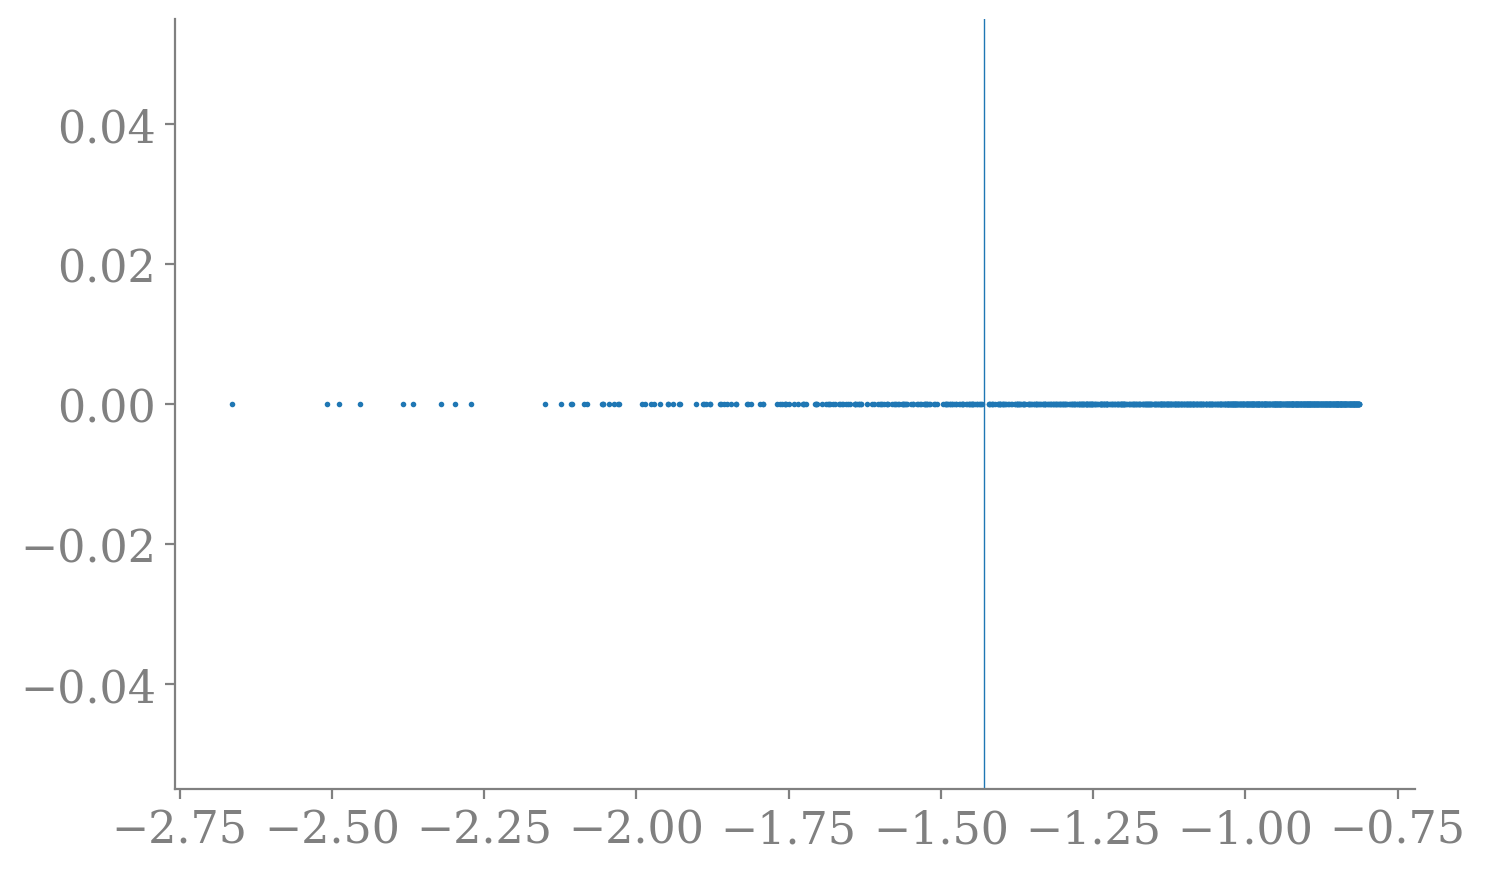

In [78]:
x = BH.evals
y = [0]*np.size(BH.evals)
# print(x, y)
plt.scatter(x, y, s=1)
thres = -1.43
plt.axvline(thres, lw=0.5)
np.size(np.where(x<thres)[0])

In [ ]:
start = time.time()
num_groups = 3000
BH.find_k_eigenvectors(num_groups, which='SA', return_eigenvectors=False)
print(f"Find {num_groups} eigenvalues take {time.time()-start} seconds!")

In [22]:
np.unique(aps_hyper_paper.H.data, return_counts=True)

(array([1]), array([1724220]))

# CD based on Bipartite Network on Papers

In [8]:
class BipartiteAps():
    def __init__(self, hyperPaper=None):
        if hyperPaper is not None:
            self.H = hyperPaper.H
            self.n = hyperPaper.n + hyperPaper.e
            self.paper_index = np.arange(hyperPaper.n)
            # self.author_index = np.arange(hyperPaper.n, self.n)
            self.paper_ids = hyperPaper.nodes
            lefttop = csr_array((hyperPaper.n, hyperPaper.n))
            rightbottom = csr_array((hyperPaper.e, hyperPaper.e))
            print(f"Construct bipartite adjacent matrix...")
            self.bipartite_A = csr_array(vstack([hstack([lefttop, self.H]), hstack([self.H.transpose(), rightbottom])]))

In [9]:
aps_hyper_paper = HyperPaper()
aps_hyper_paper.max_component(connected_components=None)

Load Authorship: 100%|██████████| 2385375/2385375 [00:05<00:00, 468914.49it/s]


Number of Author 868506, Number of Paper 678916 
 Average #_papers per author 2.7464692241619515 
 Average #_coauthors per paper 3.5134317058369517 



Load Citation: 100%|██████████| 8767868/8767868 [00:14<00:00, 614444.25it/s]


Average #_cited_papers per citing_paper 12.914510778947616 

There are 661105 authors with 1 paper: number of order_1 hyperedge. To be removed!
There are 75916 papers with 0 author: number of degree_0 nodes. To be removed!
Hypergraph on papers, each author is a hyperedge. n=603000, e=207401
 Ks & #hyperedge per order=[[    2     3     4     5     6     7     8     9    10    11    12    13
     14    15    16    17    18    19    20    21    22    23    24    25
     26    27    28    29    30    31    32    33    34    35    36    37
     38    39    40    41    42    43    44    45    46    47    48    49
     50    51    52    53    54    55    56    57    58    59    60    61
     62    63    64    65    66    67    68    69    70    71    72    73
     74    75    76    77    78    79    80    81    82    83    84    85
     86    87    88    89    90    91    92    93    94    95    96    97
     98    99   100   101   102   103   104   105   106   107   108   109
    110   111  

In [10]:
aps_bipartite_paper = BipartiteAps(aps_hyper_paper)

Construct bipartite adjacent matrix...


In [12]:
start = time.time()
given_num_groups = 168
save_path = f"./result/partition_paper_bipartite_maxcomponent_given{given_num_groups}Groups.pkl"
partition_vec, _ = CommunityDetect(aps_bipartite_paper.bipartite_A).BetheHessian(num_groups=given_num_groups,
                                                                    only_assortative=True)
with open(save_path, "wb") as fw:
        pickle.dump(partition_vec, fw)
print(f"Time cost {time.time()-start}")

Get BH operator, done!
EVECs construct: 10171.817452669144
Time cost 12795.408214569092


In [13]:
print(partition_vec[aps_bipartite_paper.paper_index])
np.unique(partition_vec[aps_bipartite_paper.paper_index], return_counts=True)

[7 7 7 ... 7 7 7]


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
       dtype=int32),
 array([ 16005,     47,     60,   

# CD based on Hypergraph on Authors

In [5]:
class HyperAuthor(APS):
    def __init__(self):
        super().__init__()
        self.n = self.author_n
        self.e = self.paper_n
        self.H = self.incidence_H
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        print(f"There are {order_count[0]} papers with 0 author, {order_count[1]} papers with 1 author: number of hyperedge to be removed!")
        self.e = self.e - order_count[0] - order_count[1]
        nonorder1or0_column = np.logical_and(self.H.sum(axis=0).flatten()!=1, self.H.sum(axis=0).flatten()!=0).nonzero()
        self.H = (self.H.tocsc()[:, nonorder1or0_column[0]]).tocsr()
        # print(np.unique(self.H.data, return_counts=True))
        node_degree, degree_count = np.unique(self.H.sum(axis=1).flatten(),  return_counts=True)
        print(f"There are {degree_count[0]} authors with 0 paper: number of degree_0 nodes. To be removed!")
        self.n = self.n - degree_count[0]
        self.nondegree0_row = (self.H.sum(axis=1).flatten()!=0).nonzero()
        self.H = self.H[self.nondegree0_row[0], :]
        
        edge_order, order_count = np.unique(self.H.sum(axis=0).flatten(), return_counts=True)
        node_degree, degree_count = np.unique(self.H.sum(axis=1).flatten(),  return_counts=True)
        self.Ks = edge_order
        
        print(f"Hypergraph on authors, each paper is a hyperedge. n={self.n}, e={self.e}, Ks & #hyperedge per order={np.array([edge_order, order_count])}")
        print(f"Ds & #nodes per degree={np.array([node_degree, degree_count])}")
        
    def get_operator(self, operator='BH', r=0, consider_ks=None, proj_matrix=None):
        if operator == "BH":
            edge_order = self.H.sum(axis=0).flatten()
            D = None
            A = None
            self.H = self.H.tocsc()
            if consider_ks is None:
                Ks = self.Ks
            else:
                Ks = consider_ks
            for k in tqdm(Ks, desc='Constructing HyperBH...'):
                edge_index = np.where(edge_order == k)[0]
                Hk = self.H[:, edge_index]
                Dk = diags(Hk.sum(axis=1).flatten().astype(float))
                Ak = Hk.dot(Hk.T) - diags(Hk.dot(Hk.T).diagonal())
                if D is None:
                    D = (k-1)/((1-r)*(r+k-1))*Dk
                else:
                    D += (k-1)/((1-r)*(r+k-1))*Dk
                if A is None:
                    A = r/((1-r)*(r+k-1))*Ak
                else:
                    A += r/((1-r)*(r+k-1))*Ak
            B = eye(D.shape[0]) - D + A
            return B
        elif operator == 'BHproj':
            d = csr_array(proj_matrix ** 2 / (csr_array(r ** 2 * np.ones((n1, n1))) - proj_matrix ** 2)).sum(axis=1).flatten().astype(float)
            d = diags(d, 0)
            d = d + csr_array(np.identity(n1))
            BH = d - csr_array((r * proj_matrix) / (csr_array(r ** 2 * np.ones((n1, n1))) - proj_matrix ** 2))
            return BH

In [6]:
aps_hyper_author = HyperAuthor()

Load Authorship: 100%|██████████| 2385375/2385375 [00:05<00:00, 450653.63it/s]


Number of Author 868506, Number of Paper 678916 
 Average #_papers per author 2.7464692241619515 
 Average #_coauthors per paper 3.5134317058369517 



Load Citation: 100%|██████████| 8767868/8767868 [00:33<00:00, 264782.87it/s]


Average #_cited_papers per citing_paper 12.914510778947616 

There are 10888 papers with 0 author, 98833 papers with 1 author: number of hyperedge to be removed!
There are 17277 authors with 0 paper: number of degree_0 nodes. To be removed!
Hypergraph on authors, each paper is a hyperedge. n=851229, e=569195, Ks & #hyperedge per order=[[     2      3      4      5      6      7      8      9     10     11
      12     13     14     15     16     17     18     19     20     21
      22     23     24     25]
 [185018 146207  88452  49775  30195  19575  13430   9214   6632   4773
    3463   2596   1944   1579   1260   1006    857    679    622    486
     425    441    315    251]]
Ds & #nodes per degree=[[     1      2      3      4      5      6      7      8      9     10
      11     12     13     14     15     16     17     18     19     20
      21     22     23     24     25     26     27     28     29     30
      31     32     33     34     35     36     37     38     39     40
 

## cd with hyper bh

In [51]:
given_num_groups = 10
consider_ks = None
author_partition_vec, _ = HyperCommunityDetect().BetheHessian(aps_hyper_author, 
                                                                num_groups=given_num_groups,
                                                                consider_ks=consider_ks,
                                                                only_assortative=True)
with open(f"./result/partition_author_hyperBH_given{given_num_groups}groups_considerOrder{consider_ks}.pkl", "wb") as fw:
        pickle.dump(author_partition_vec, fw)

Constructing HyperBH...: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


EVECs construct: 92.74389004707336


In [53]:
np.unique(author_partition_vec, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([851093,     15,      3,     12,     17,     16,      4,     10,
            13,     46]))

## cd with proj bh

In [ ]:
given_num_groups = 10
author_partition_vec, _ = HyperCommunityDetect().ProjBH(aps_hyper_author, num_groups=given_num_groups, only_assortative=True)
with open(f"./result/partition_author_projBH_given{given_num_groups}groups.pkl", "wb") as fw:
        pickle.dump(author_partition_vec, fw)

Construct projected weighted matrix, do weighted BH on it...
